In [13]:
import pandas as pd

# 1) load the file (adjust filename and separator if needed)
df = pd.read_csv("youtoxic_english_1000.csv", sep=",")  

# 2) identify the text column and the other label columns
text_col = "Text"
exclude = ["CommentId", "VideoId", text_col]
# all columns that are candidate toxicity flags:

tox_cols = [c for c in df.columns if c not in exclude]

# 3) convert each toxicity cell to a boolean (True if it indicates toxicity)
# This works for booleans and for strings like "TRUE"/"FALSE" (case-insensitive).
tox_bool = df[tox_cols].applymap(lambda x: str(x).strip().upper() == "TRUE")

# 4) create the single label: 1 if any toxicity flag is True, else 0
df["label"] = tox_bool.any(axis=1).astype(int)

# 5) keep only text and label columns
out = df[[text_col, "label"]]

# 6) save to new CSV
out.to_csv("youtube_comment.csv", index=False)


In [24]:
data=pd.read_csv("youtube_comment.csv")
print(data.head(2))

                                                Text  label
0  If only people would just take a step back and...      0
1  Law enforcement is not trained to shoot to app...      1


*code implementation*

Original shape: (1000, 2)
Original class counts:
 label
0    538
1    462
Name: count, dtype: int64

Balanced class counts:
 label
1    538
0    538
Name: count, dtype: int64

--- Sample Predictions ---
I hate this video -> Non-Hate
Great content, loved it! -> Non-Hate
This creator is stupid -> Hate Speech
Such an inspiring message, thank you! -> Non-Hate

Accuracy: 0.8055555555555556

Classification Report:
               precision    recall  f1-score   support

    Non-Hate       0.83      0.77      0.80       108
 Hate Speech       0.78      0.84      0.81       108

    accuracy                           0.81       216
   macro avg       0.81      0.81      0.81       216
weighted avg       0.81      0.81      0.81       216



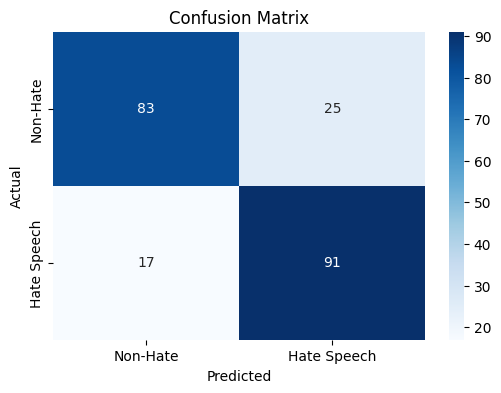

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# =======================
# 1. Load Dataset
# =======================
df = pd.read_csv("youtube_comment.csv")

print("Original shape:", df.shape)
print("Original class counts:\n", df["label"].value_counts())

# =======================
# 2. Balance Dataset (Upsampling)
# =======================
df_majority = df[df["label"] == 0]
df_minority = df[df["label"] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,                 # sample with replacement
    n_samples=len(df_majority),   # match majority class
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced class counts:\n", df_balanced["label"].value_counts())

# =======================
# 3. Train-Test Split
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["Text"],
    df_balanced["label"],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced["label"]
)

# =======================
# 4. TF-IDF Vectorizer
# =======================
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# =======================
# 5. Train Logistic Regression
# =======================
model = LogisticRegression(max_iter=200)
model.fit(X_train_vec, y_train)

# =======================
# 6. Predictions
# =======================
y_pred = model.predict(X_test_vec)

# Test on custom comments
new_comments = [
    "I hate this video",
    "Great content, loved it!",
    "This creator is stupid",
    "Such an inspiring message, thank you!"
]
new_vec = vectorizer.transform(new_comments)
predictions = model.predict(new_vec)

print("\n--- Sample Predictions ---")
for text, label in zip(new_comments, predictions):
    print(text, "->", "Hate Speech" if label == 1 else "Non-Hate")

# =======================
# 7. Evaluation
# =======================
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, labels=[0, 1],
                            target_names=["Non-Hate", "Hate Speech"]))

# =======================
# 8. Confusion Matrix
# =======================
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Hate", "Hate Speech"],
            yticklabels=["Non-Hate", "Hate Speech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [28]:
# Support Vector Machine Model
# =======================
svm_model = SVC(kernel="linear")   # linear kernel works well for text
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

print("\n--- SVM ---")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n",
      classification_report(y_test, y_pred_svm,
                            target_names=["Non-Hate", "Hate Speech"]))
predictions_svm = svm_model.predict(new_vec)
print("\n--- Sample Predictions (SVM) ---")
for text, label in zip(new_comments, predictions_svm):
    print(text, "->", "Hate Speech" if label == 1 else "Non-Hate")


--- SVM ---
Accuracy: 0.8101851851851852
Classification Report:
               precision    recall  f1-score   support

    Non-Hate       0.83      0.78      0.80       108
 Hate Speech       0.79      0.84      0.82       108

    accuracy                           0.81       216
   macro avg       0.81      0.81      0.81       216
weighted avg       0.81      0.81      0.81       216


--- Sample Predictions (SVM) ---
I hate this video -> Non-Hate
Great content, loved it! -> Non-Hate
This creator is stupid -> Hate Speech
Such an inspiring message, thank you! -> Non-Hate
